In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [11]:
df=pd.read_csv("../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [12]:
## processing
df_columns = df.columns # 列名をリストとして取得
import re

# 正規表現パターンを作成します
pattern = r'id|^elasped_(m[0-5]|[0-9]|1\d|20)$'

# 列名のリストを作成します
column_names = [col for col in df_columns if re.search(pattern, col)]

# 列名のリストを表示します
print(column_names)
rest_columns=["year","generic_per","month","year_month"]
column_names=rest_columns+column_names
# try:
#     column_names.remove("elasped_m1")
# except:
#     1

try:
    column_names.remove("elasped")
except:
    1
try:
    column_names.remove("id")
except:
    1
# try:
#     column_names.remove("id_114")
# except:
#     1
# column_names

['id', 'elasped_m5', 'elasped_m4', 'elasped_m3', 'elasped_m2', 'elasped_m1', 'elasped_0', 'elasped_1', 'elasped_2', 'elasped_3', 'elasped_4', 'elasped_5', 'elasped_6', 'elasped_7', 'elasped_8', 'elasped_9', 'elasped_10', 'elasped_11', 'elasped_12', 'elasped_13', 'elasped_14', 'elasped_15', 'elasped_16', 'elasped_17', 'elasped_18', 'elasped_19', 'elasped_20', 'id_114', 'id_121', 'id_123', 'id_124', 'id_131', 'id_132', 'id_211', 'id_217', 'id_218', 'id_222', 'id_223', 'id_224', 'id_225', 'id_229', 'id_231', 'id_232', 'id_235', 'id_239', 'id_245', 'id_252', 'id_259', 'id_264', 'id_265', 'id_279', 'id_313', 'id_321', 'id_332', 'id_339', 'id_391', 'id_399', 'id_441', 'id_449', 'id_625', 'id_629', 'id_799']


In [13]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
5867    0
5868    0
5869    0
5870    0
5871    0
Name: mon_1, Length: 5872, dtype: uint8

In [14]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [15]:
# change to the datetime format
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=26))
df=df.set_index(["id","year_month"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2339 entries, (114, Timestamp('2009-11-26 00:00:00')) to (799, Timestamp('2022-12-26 00:00:00'))
Columns: 125 entries, year to year_trend
dtypes: float64(11), int32(3), int64(93), object(6), uint8(12)
memory usage: 2.0+ MB


(125, 167, 27)

In [19]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [17]:
formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# stock lag
# formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_rx_lag+TimeEffects+EntityEffects"

# with month dummies
# formula+=months

# ytrend
# formula+=ytrend

# mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# drop_absorbed=True
mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5 -1.343e+06   4.32e+05    -3.1075     0.0019   -2.19e+06  -4.953e+05
elasped_m4  -1.71e+06  4.756e+05    -3.5951     0.0003  -2.643e+06  -7.772e+05
elasped_m3  -8.64e+05  1.911e+06    -0.4522     0.6512  -4.611e+06   2.883e+06
elasped_m2 -1.411e+06  9.527e+05    -1.4809     0.1388  -3.279e+06   4.574e+05
elasped_m1 -2.814e+06  8.201e+05    -3.4320     0.0006  -4.423e+06  -1.206e+06
elasped_0  -3.122e+06  6.826e+05    -4.5743     0.0000  -4.461e+06  -1.784e+06
elasped_1  -2.699e+06   6.73e+05    -4.0105     0.0001  -4.019e+06  -1.379e+06
elasped_2  -1.163e+06  6.802e+05    -1.7106     0.0873  -2.497e+06   1.704e+05
elasped_3  -1.447e+05  5.258e+05    -0.2753     0.7831  -1.176e+06   8.864e+05
elasped_4   -1.17e+06  6.779e+05    -1.7266     0.08

C:\Users\hakos\AppData\Local\Temp\ipykernel_17712\1095135707.py:13: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


In [21]:
# take log
formula="log_rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version and month dummies
# formula="log_rx_dom ~ generic_per+log_stock_rx_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# with months
# formula+=months

# ytrend
# formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5    -0.0750     0.1540    -0.4868     0.6264     -0.3770      0.2270
elasped_m4    -0.2802     0.1004    -2.7892     0.0053     -0.4772     -0.0832
elasped_m3    -0.0772     0.0791    -0.9763     0.3290     -0.2322      0.0779
elasped_m2    -0.1154     0.0588    -1.9607     0.0500     -0.2308   2.034e-05
elasped_m1    -0.1553     0.0576    -2.6973     0.0070     -0.2682     -0.0424
elasped_0     -0.2095     0.0529    -3.9605     0.0001     -0.3133     -0.1058
elasped_1     -0.1611     0.0667    -2.4165     0.0158     -0.2918     -0.0304
elasped_2     -0.1188     0.0694    -1.7122     0.0870     -0.2550      0.0173
elasped_3      0.0365     0.0554     0.6593     0.5098     -0.0721      0.1452
elasped_4      0.0259     0.0783     0.3311     0.74

C:\Users\hakos\AppData\Local\Temp\ipykernel_17712\3469882702.py:13: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


### OTC

In [22]:

formula="otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# without stock lag
# formula="otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+EntityEffects+TimeEffects"

# stock lag only
# formula="otc_dom ~ stock_otc_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# with months
# formula+=months

ytrend
formula+=ytrend
mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5 -6.943e+04  2.201e+05    -0.3154     0.7525  -5.012e+05   3.623e+05
elasped_m4 -2.507e+05  1.993e+05    -1.2581     0.2085  -6.416e+05   1.401e+05
elasped_m3 -3.778e+05  2.309e+05    -1.6363     0.1019  -8.306e+05   7.499e+04
elasped_m2  -1.49e+05  3.948e+05    -0.3775     0.7058  -9.233e+05   6.252e+05
elasped_m1  4.556e+05  2.829e+05     1.6107     0.1074  -9.912e+04    1.01e+06
elasped_0   3.893e+05  2.789e+05     1.3956     0.1630  -1.577e+05   9.363e+05
elasped_1   6.632e+05  3.503e+05     1.8934     0.0584  -2.371e+04    1.35e+06
elasped_2   3.156e+05  4.373e+05     0.7218     0.4705  -5.419e+05   1.173e+06
elasped_3  -1.301e+05  3.957e+05    -0.3287     0.7424  -9.061e+05   6.459e+05
elasped_4  -4.425e+05  3.859e+05    -1.1466     0.25

C:\Users\hakos\AppData\Local\Temp\ipykernel_17712\1328480728.py:14: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per, year_trend

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


In [23]:
# take log

# till 20
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+generic_per+TimeEffects+EntityEffects"

# till 15
# formula="log_otc_dom ~ generic_per+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# add lagged stock
formula+="+log_stock_otc_lag"

# with month dummies
# formula+=months

# ytrend
formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elasped_m5           -1.0392     0.5612    -1.8518     0.0642     -2.1397      0.0613
elasped_m4           -0.8377     0.3316    -2.5264     0.0116     -1.4879     -0.1875
elasped_m3           -0.5499     0.3196    -1.7208     0.0854     -1.1766      0.0768
elasped_m2            0.0427     0.4712     0.0906     0.9278     -0.8813      0.9667
elasped_m1           -0.1113     0.3590    -0.3101     0.7565     -0.8154      0.5927
elasped_0            -0.1623     0.3345    -0.4851     0.6276     -0.8183      0.4937
elasped_1            -0.0690     0.3937    -0.1754     0.8608     -0.8411      0.7030
elasped_2            -0.8322     0.4139    -2.0104     0.0445     -1.6439     -0.0204
elasped_3            -0.6672     0.5311    -1.2563    

C:\Users\hakos\AppData\Local\Temp\ipykernel_17712\2913409798.py:19: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per, year_trend

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


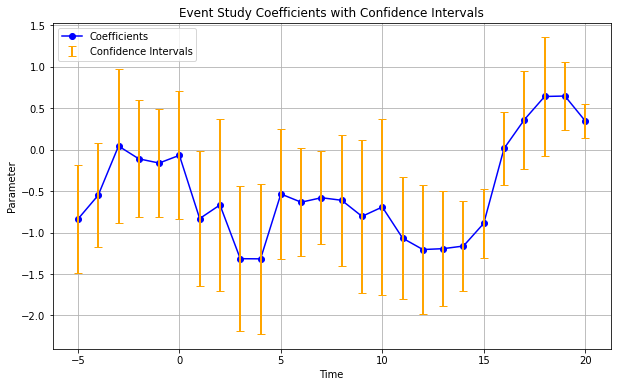

In [24]:
# 天才やん
summary_table=pd.DataFrame(res_fe.summary.tables[1].data[2:28],columns=res_fe.summary.tables[1].data[0])
summary_table["Time"]=np.array(list(range(-5,21)))
# make each column of summary_table numeric
summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot coefficients as points
plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

# Plot confidence intervals as error bars
plt.errorbar(summary_table['Time'], summary_table["Parameter"],
             yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
                   summary_table['Upper CI'] - summary_table["Parameter"]],
             fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

plt.xlabel('Time')
plt.ylabel("Parameter")
plt.title('Event Study Coefficients with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()